# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Homework 9:  ANNs


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Import libraries:

In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import keras 
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle

Using TensorFlow backend.


<hr style='height:2pt'>
<div class='theme'> Neural Networks </div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{-2\pi i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original f(x) looks like a wave with period s. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this pset is this: function goes in, re-write in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 2$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4.

Questions 1.1 and 1.2 will get you used to the format of the data.

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> <b> Question 1 [50pts] <b> </div>
**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve.

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**1.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [3]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [4]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

### Answers:  

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

Text(0.5,1,'first row of X_train')

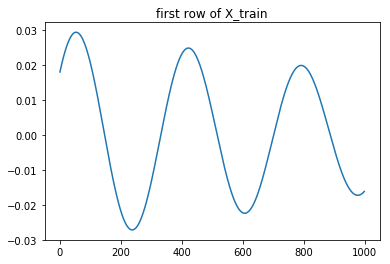

In [5]:
plt.plot(X_train[0,:])
plt.title("first row of X_train")

It is sinusoidal!

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

In [6]:
# your code here
def reverse_fourier(y1,y2,y3,y4):
    f = lambda x: y1*np.sin(y2*x)+y3*np.cos(y4*x)
    return f

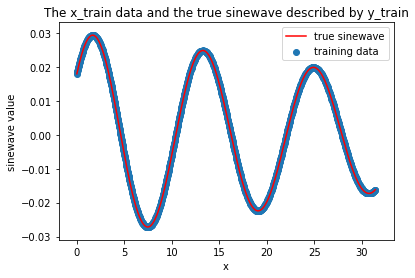

In [7]:
f = reverse_fourier(y_train[0,0],y_train[0,1],y_train[0,2],y_train[0,3])
x = np.linspace(0,10*np.pi,1000)
plt.plot(x, f(x), color = 'red', label = 'true sinewave')
plt.scatter(x, X_train[0,:], label = 'training data')
plt.xlabel('x')
plt.ylabel('sinewave value')
plt.legend()
plt.title("The x_train data and the true sinewave described by y_train")
plt.show()

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [8]:
# your code here
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=1000))
model.add(Dense(units=16, activation='relu')) 
model.add(Dense(units=4))

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [9]:
# your code here
model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 65,172
Trainable params: 65,172
Non-trainable params: 0
_________________________________________________________________


----
Your answer here
The first layer has 64064 parameters because each node in layer 1 has 1000 parameters for each input plus 1 bias parameters.

This means that there should be $64 \times 1000 + 64 \times 1 = 64 064$ parameters in the first layer, as observed.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [11]:
# your code here
model.fit(X_train, y_train, epochs=75, batch_size=32, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/75
8000/8000 [==============================] - 1s 79us/step - loss: 0.2002 - val_loss: 0.1439
Epoch 2/75
8000/8000 [==============================] - 0s 60us/step - loss: 0.1251 - val_loss: 0.1100
Epoch 3/75
8000/8000 [==============================] - 1s 65us/step - loss: 0.1033 - val_loss: 0.0962
Epoch 4/75
8000/8000 [==============================] - 0s 61us/step - loss: 0.0899 - val_loss: 0.0843
Epoch 5/75
8000/8000 [==============================] - 0s 61us/step - loss: 0.0844 - val_loss: 0.0831
Epoch 6/75
8000/8000 [==============================] - 0s 61us/step - loss: 0.0793 - val_loss: 0.0770
Epoch 7/75
8000/8000 [==============================] - 1s 63us/step - loss: 0.0760 - val_loss: 0.0729
Epoch 8/75
8000/8000 [==============================] - 1s 67us/step - loss: 0.0710 - val_loss: 0.0674
Epoch 9/75
8000/8000 [==============================] - 0s 57us/step - loss: 0.0683 - val_loss: 0.0666
Epoch 10/75
8000/8000 [==

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

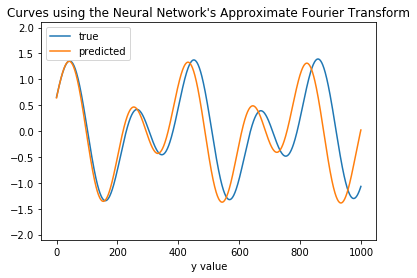

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.86999345 1.0236945  0.64175546 0.5153728 ]


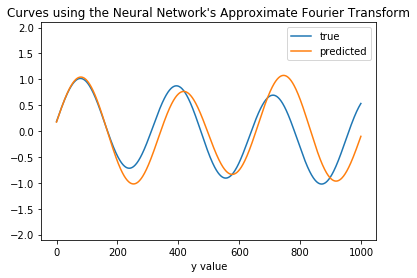

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.91290563 0.6017617  0.17470305 0.283667  ]


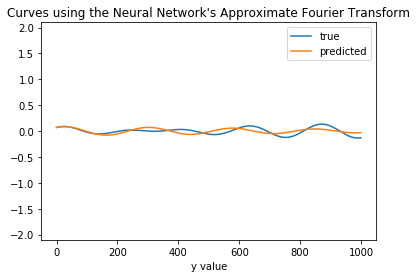

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.04898883 0.69550693 0.07144059 0.7319591 ]


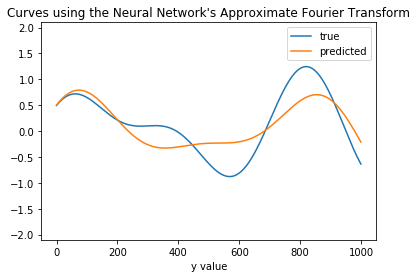

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.75225264 0.3256001  0.5020611  0.42715037]


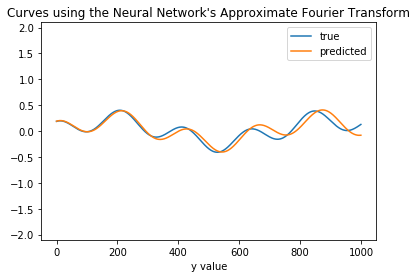

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.21779624 0.28652287 0.19066267 0.91510826]


In [12]:
plot_predictions(model, X_test, y_test)

In [13]:
model.evaluate(X_test,y_test)

2000/2000 [==============================] - 0s 18us/step


0.035660766631364825

----
**Report the model's overall loss on the test set.**

The model's loss on the test set is 0.034

**Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?**

The model predicts the coefficients pretty well. However, when we recreate the sinusoidal data from the coefficients, the predicted curve gets increasingly divergent from the original curve at higher x values.

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

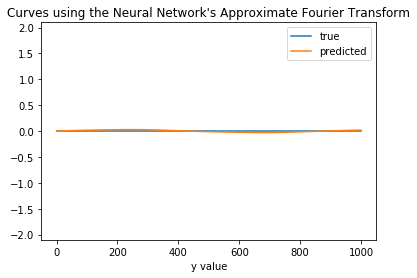

true: [0. 0. 0. 0.]
predicted: [0.02780331 0.22685683 0.00199215 0.69877553]


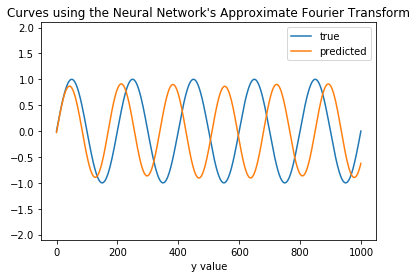

true: [1. 1. 0. 0.]
predicted: [ 0.8908934   1.1758093  -0.02668707  0.3642555 ]


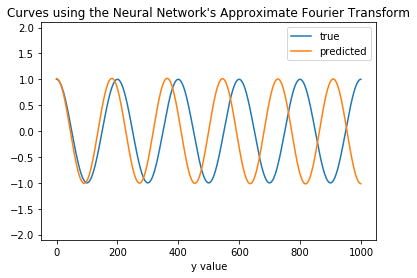

true: [0. 0. 1. 1.]
predicted: [0.00690118 0.18466479 1.0126295  1.1000335 ]


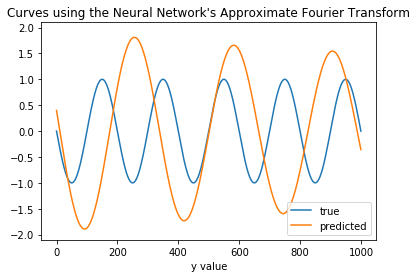

true: [-1.  1.  0.  0.]
predicted: [ 1.896416   -0.61016524  0.39871505  0.57040143]


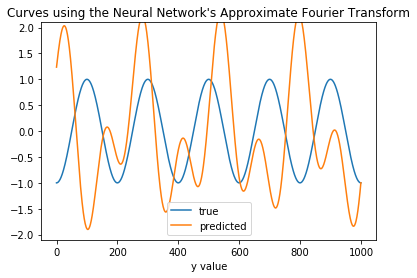

true: [ 0.  0. -1.  1.]
predicted: [ 1.0621685  1.5752645  1.2350804 -0.7434264]


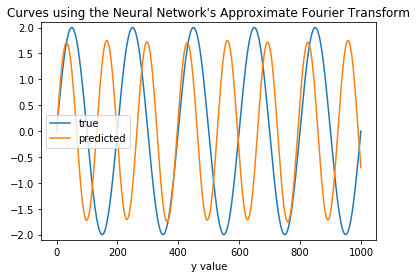

true: [2. 1. 0. 0.]
predicted: [ 1.7258799   1.5137789  -0.02440314  0.52439547]


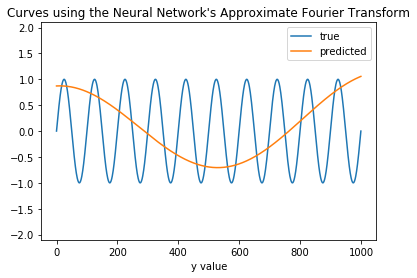

true: [1. 2. 0. 0.]
predicted: [0.3234838  0.03204279 0.8715768  0.18551424]


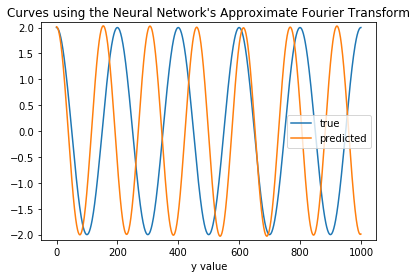

true: [0. 0. 2. 1.]
predicted: [0.01941893 0.24667618 2.0139792  1.3024819 ]


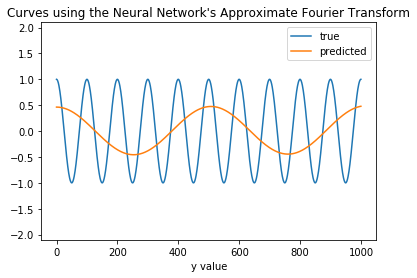

true: [0. 0. 1. 2.]
predicted: [-0.04132552 -0.01900119  0.4632437  -0.39430016]


In [14]:
# your code here
plot_predictions(model, X_extended_test, y_extended_test, count=9)

----
Your answer here

The model struggles when the true parameters are either greater than 1 or less than 0.

**1.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

The difficult observations are out of sample, since our data was generated with parameters between [0, 1]. This means that the model did not properly learn the fourier transform because if it had, it would generalize to all parameters. The model is overfit, because it fit to our specific samples rather than the underlying data generating process (the parameterized sinusoidal curve).

<hr style='height:2pt'>

## Regulrizing Neural Networks

In this problem set we have already explored how ANN are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size), and how well the neural network can generalize. In this problem we focus on issues of overfitting and regularization in Neural Networks.

As we have explained in class, ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns don't generalize to fresh data.

There are several methods used to improve ANN generalization. One approach is to use an achitecutre just barely wide/deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and computationally costly to hunt for a correct size. Given this, other methodologies are used to fight overfitting and improve the ANN generalization. These, like other techniques to combat overfitting, fall under the umbrella of Regularization.

In this problem you are asked to regularize a network given to you below. The train dataset can be generated using the code also given below. 




<div class='exercise'> <b> Question 2 [50 pts] </b> </div>


**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU 
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 2,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

We will evaluate your model on a test set we've kept secret. 

1. Don't try to use extra data from NMIST. We will re-train your model on training set under the settings above. 
2. Keep the  architecture above as is. In other words keep the number of layers, number of nodes, activation function, and loss fucntion the same. You can change the number of epochs (max 2000), batch size, optimizer and of course add elements that can help to regularize (e.g. drop out, L2 norm etc). You can also do data augmentation. 
3. You *may* import new modules, following the citation rule above.

Grading: Your score will be based on how much you can improve on the test score via regularization:
1.  (0-1] percent will result into 10 pts
2.  (1-2] percent will result into 20 pts
3.  (2-3] percent will result into 30 pts
4.   Above 3 percent will result in 35 pts
6.   Top 15 groups or single students will be awarded an additional 10 pts
7.   The overall winner(s) will be awarded an additional 5 pts

**2.1** **Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

In [15]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [16]:
def preprocess(x, y):    
    select = np.logical_or(y == 4, y == 9)
    x_subset = x[select]
    y_subset = y[select]

    idx = np.random.randint(len(y_subset), size=800)
    x_800 = x_subset[idx]
    y_800 = y_subset[idx]

    y_binary = np.array([0 if y == 4 else 1 for y in y_800])

    # Preprocess data using keras.utils.to_categorical
    # your code here 
    y_final = keras.utils.to_categorical(y_binary)

    # scale the data otherwise reLU can become unstable 
    # your code here 
    x_scaled = x_800/255
    x_final = x_scaled.reshape(-1,28*28)
    
    return x_final, y_final

x_train_final, y_train_final = preprocess(x_train, y_train)

x_test_final, y_test_final = preprocess(x_test, y_test)

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

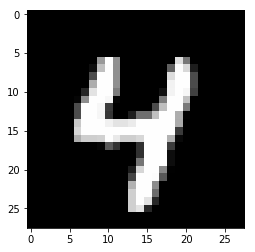

In [17]:
# your code here
plt.imshow(x_train_final.reshape(-1,28,28)[y_train_final[:, 0] == True][0], cmap = plt.get_cmap('gray'))

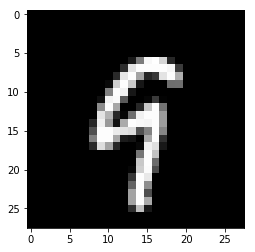

In [18]:
plt.imshow(x_train_final.reshape(-1,28,28)[y_train_final[:, 1] == True][0], cmap = plt.get_cmap('gray'))

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 1,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

In [19]:
# your code here
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=28*28))
model.add(Dense(units=100, activation='relu')) 
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 98,902
Trainable params: 98,902
Non-trainable params: 0
_________________________________________________________________


In [20]:
#your code here
history = model.fit(x_train_final, y_train_final, epochs = 1000, batch_size=128, validation_split=.5)

Train on 400 samples, validate on 400 samples
Epoch 1/1000
400/400 [==============================] - 0s 553us/step - loss: 0.7058 - acc: 0.4788 - val_loss: 0.7061 - val_acc: 0.4550
Epoch 2/1000
400/400 [==============================] - 0s 35us/step - loss: 0.7028 - acc: 0.4800 - val_loss: 0.7036 - val_acc: 0.4650
Epoch 3/1000
400/400 [==============================] - 0s 34us/step - loss: 0.7004 - acc: 0.4875 - val_loss: 0.7015 - val_acc: 0.4675
Epoch 4/1000
400/400 [==============================] - 0s 35us/step - loss: 0.6980 - acc: 0.4987 - val_loss: 0.6995 - val_acc: 0.4863
Epoch 5/1000
400/400 [==============================] - 0s 35us/step - loss: 0.6958 - acc: 0.5150 - val_loss: 0.6972 - val_acc: 0.4975
Epoch 6/1000
400/400 [==============================] - 0s 36us/step - loss: 0.6934 - acc: 0.5375 - val_loss: 0.6951 - val_acc: 0.5150
Epoch 7/1000
400/400 [==============================] - 0s 34us/step - loss: 0.6911 - acc: 0.5350 - val_loss: 0.6929 - val_acc: 0.5100
Epoch 8/

Epoch 61/1000
400/400 [==============================] - 0s 35us/step - loss: 0.4222 - acc: 0.9200 - val_loss: 0.4409 - val_acc: 0.8988
Epoch 62/1000
400/400 [==============================] - 0s 34us/step - loss: 0.4134 - acc: 0.9237 - val_loss: 0.4327 - val_acc: 0.8988
Epoch 63/1000
400/400 [==============================] - 0s 34us/step - loss: 0.4049 - acc: 0.9263 - val_loss: 0.4253 - val_acc: 0.8975
Epoch 64/1000
400/400 [==============================] - 0s 31us/step - loss: 0.3975 - acc: 0.9275 - val_loss: 0.4175 - val_acc: 0.8975
Epoch 65/1000
400/400 [==============================] - 0s 31us/step - loss: 0.3886 - acc: 0.9312 - val_loss: 0.4105 - val_acc: 0.9025
Epoch 66/1000
400/400 [==============================] - 0s 31us/step - loss: 0.3805 - acc: 0.9337 - val_loss: 0.4026 - val_acc: 0.9012
Epoch 67/1000
400/400 [==============================] - 0s 32us/step - loss: 0.3723 - acc: 0.9337 - val_loss: 0.3948 - val_acc: 0.9025
Epoch 68/1000
400/400 [=========================

400/400 [==============================] - 0s 40us/step - loss: 0.1301 - acc: 0.9650 - val_loss: 0.1877 - val_acc: 0.9513
Epoch 122/1000
400/400 [==============================] - 0s 43us/step - loss: 0.1280 - acc: 0.9688 - val_loss: 0.1881 - val_acc: 0.9400
Epoch 123/1000
400/400 [==============================] - 0s 41us/step - loss: 0.1271 - acc: 0.9675 - val_loss: 0.1862 - val_acc: 0.9450
Epoch 124/1000
400/400 [==============================] - 0s 35us/step - loss: 0.1250 - acc: 0.9662 - val_loss: 0.1832 - val_acc: 0.9525
Epoch 125/1000
400/400 [==============================] - 0s 34us/step - loss: 0.1233 - acc: 0.9688 - val_loss: 0.1817 - val_acc: 0.9537
Epoch 126/1000
400/400 [==============================] - 0s 34us/step - loss: 0.1218 - acc: 0.9700 - val_loss: 0.1836 - val_acc: 0.9400
Epoch 127/1000
400/400 [==============================] - 0s 33us/step - loss: 0.1214 - acc: 0.9675 - val_loss: 0.1825 - val_acc: 0.9425
Epoch 128/1000
400/400 [==============================] 

Epoch 181/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0709 - acc: 0.9825 - val_loss: 0.1534 - val_acc: 0.9500
Epoch 182/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0698 - acc: 0.9825 - val_loss: 0.1536 - val_acc: 0.9513
Epoch 183/1000
400/400 [==============================] - 0s 43us/step - loss: 0.0692 - acc: 0.9825 - val_loss: 0.1528 - val_acc: 0.9513
Epoch 184/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0686 - acc: 0.9838 - val_loss: 0.1527 - val_acc: 0.9487
Epoch 185/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0685 - acc: 0.9838 - val_loss: 0.1525 - val_acc: 0.9500
Epoch 186/1000
400/400 [==============================] - 0s 39us/step - loss: 0.0672 - acc: 0.9850 - val_loss: 0.1525 - val_acc: 0.9500
Epoch 187/1000
400/400 [==============================] - 0s 44us/step - loss: 0.0669 - acc: 0.9838 - val_loss: 0.1520 - val_acc: 0.9513
Epoch 188/1000
400/400 [=================

Epoch 241/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0456 - acc: 0.9925 - val_loss: 0.1505 - val_acc: 0.9525
Epoch 242/1000
400/400 [==============================] - 0s 39us/step - loss: 0.0449 - acc: 0.9925 - val_loss: 0.1507 - val_acc: 0.9525
Epoch 243/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0444 - acc: 0.9950 - val_loss: 0.1504 - val_acc: 0.9487
Epoch 244/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0446 - acc: 0.9925 - val_loss: 0.1508 - val_acc: 0.9513
Epoch 245/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0440 - acc: 0.9925 - val_loss: 0.1521 - val_acc: 0.9525
Epoch 246/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0440 - acc: 0.9900 - val_loss: 0.1515 - val_acc: 0.9500
Epoch 247/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0434 - acc: 0.9950 - val_loss: 0.1543 - val_acc: 0.9463
Epoch 248/1000
400/400 [=================

Epoch 301/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0304 - acc: 0.9975 - val_loss: 0.1550 - val_acc: 0.9500
Epoch 302/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0304 - acc: 0.9975 - val_loss: 0.1549 - val_acc: 0.9500
Epoch 303/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0299 - acc: 0.9988 - val_loss: 0.1548 - val_acc: 0.9500
Epoch 304/1000
400/400 [==============================] - 0s 41us/step - loss: 0.0298 - acc: 0.9975 - val_loss: 0.1549 - val_acc: 0.9500
Epoch 305/1000
400/400 [==============================] - 0s 42us/step - loss: 0.0295 - acc: 0.9988 - val_loss: 0.1550 - val_acc: 0.9500
Epoch 306/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0295 - acc: 0.9988 - val_loss: 0.1555 - val_acc: 0.9500
Epoch 307/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0294 - acc: 0.9988 - val_loss: 0.1553 - val_acc: 0.9500
Epoch 308/1000
400/400 [=================

Epoch 361/1000
400/400 [==============================] - 0s 42us/step - loss: 0.0213 - acc: 1.0000 - val_loss: 0.1597 - val_acc: 0.9500
Epoch 362/1000
400/400 [==============================] - 0s 41us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 0.1593 - val_acc: 0.9475
Epoch 363/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.1591 - val_acc: 0.9500
Epoch 364/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0207 - acc: 1.0000 - val_loss: 0.1593 - val_acc: 0.9487
Epoch 365/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.1594 - val_acc: 0.9500
Epoch 366/1000
400/400 [==============================] - 0s 40us/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.1595 - val_acc: 0.9500
Epoch 367/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.1612 - val_acc: 0.9525
Epoch 368/1000
400/400 [=================

Epoch 421/1000
400/400 [==============================] - 0s 61us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.1655 - val_acc: 0.9475
Epoch 422/1000
400/400 [==============================] - 0s 56us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 0.9487
Epoch 423/1000
400/400 [==============================] - 0s 52us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 0.9475
Epoch 424/1000
400/400 [==============================] - 0s 66us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.1659 - val_acc: 0.9500
Epoch 425/1000
400/400 [==============================] - 0s 54us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 0.9475
Epoch 426/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 0.9475
Epoch 427/1000
400/400 [==============================] - 0s 44us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 0.9475
Epoch 428/1000
400/400 [=================

400/400 [==============================] - 0s 38us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.1701 - val_acc: 0.9475
Epoch 481/1000
400/400 [==============================] - 0s 40us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.1702 - val_acc: 0.9475
Epoch 482/1000
400/400 [==============================] - 0s 42us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.1708 - val_acc: 0.9487
Epoch 483/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.1707 - val_acc: 0.9475
Epoch 484/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.1709 - val_acc: 0.9475
Epoch 485/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.1729 - val_acc: 0.9525
Epoch 486/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.1725 - val_acc: 0.9525
Epoch 487/1000
400/400 [==============================] 

Epoch 540/1000
400/400 [==============================] - 0s 39us/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.1760 - val_acc: 0.9500
Epoch 541/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.1761 - val_acc: 0.9500
Epoch 542/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.1760 - val_acc: 0.9500
Epoch 543/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.1759 - val_acc: 0.9487
Epoch 544/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.1764 - val_acc: 0.9500
Epoch 545/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.1763 - val_acc: 0.9500
Epoch 546/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.1763 - val_acc: 0.9500
Epoch 547/1000
400/400 [=================

Epoch 600/1000
400/400 [==============================] - 0s 46us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1805 - val_acc: 0.9500
Epoch 601/1000
400/400 [==============================] - 0s 45us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1810 - val_acc: 0.9525
Epoch 602/1000
400/400 [==============================] - 0s 45us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1808 - val_acc: 0.9500
Epoch 603/1000
400/400 [==============================] - 0s 45us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1810 - val_acc: 0.9525
Epoch 604/1000
400/400 [==============================] - 0s 45us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1811 - val_acc: 0.9525
Epoch 605/1000
400/400 [==============================] - 0s 43us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.1813 - val_acc: 0.9525
Epoch 606/1000
400/400 [==============================] - 0s 44us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.1812 - val_acc: 0.9500
Epoch 607/1000
400/400 [=================

Epoch 660/1000
400/400 [==============================] - 0s 55us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.1875 - val_acc: 0.9525
Epoch 661/1000
400/400 [==============================] - 0s 45us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1878 - val_acc: 0.9525
Epoch 662/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.1876 - val_acc: 0.9525
Epoch 663/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1873 - val_acc: 0.9500
Epoch 664/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1877 - val_acc: 0.9500
Epoch 665/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1879 - val_acc: 0.9525
Epoch 666/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.1876 - val_acc: 0.9500
Epoch 667/1000
400/400 [=================

Epoch 720/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.1904 - val_acc: 0.9500
Epoch 721/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1905 - val_acc: 0.9500
Epoch 722/1000
400/400 [==============================] - 0s 37us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1907 - val_acc: 0.9475
Epoch 723/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9500
Epoch 724/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9500
Epoch 725/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1910 - val_acc: 0.9500
Epoch 726/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1909 - val_acc: 0.9500
Epoch 727/1000
400/400 [=================

Epoch 780/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1948 - val_acc: 0.9500
Epoch 781/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1946 - val_acc: 0.9487
Epoch 782/1000
400/400 [==============================] - 0s 48us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1946 - val_acc: 0.9475
Epoch 783/1000
400/400 [==============================] - 0s 38us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1947 - val_acc: 0.9500
Epoch 784/1000
400/400 [==============================] - 0s 43us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1948 - val_acc: 0.9500
Epoch 785/1000
400/400 [==============================] - 0s 40us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1949 - val_acc: 0.9500
Epoch 786/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1956 - val_acc: 0.9525
Epoch 787/1000
400/400 [=================

Epoch 840/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1976 - val_acc: 0.9500
Epoch 841/1000
400/400 [==============================] - 0s 36us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1977 - val_acc: 0.9500
Epoch 842/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1977 - val_acc: 0.9500
Epoch 843/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1978 - val_acc: 0.9500
Epoch 844/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1978 - val_acc: 0.9500
Epoch 845/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1976 - val_acc: 0.9500
Epoch 846/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.1976 - val_acc: 0.9500
Epoch 847/1000
400/400 [=================

Epoch 900/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2007 - val_acc: 0.9525
Epoch 901/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2006 - val_acc: 0.9500
Epoch 902/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2006 - val_acc: 0.9500
Epoch 903/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2008 - val_acc: 0.9525
Epoch 904/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2007 - val_acc: 0.9525
Epoch 905/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2008 - val_acc: 0.9525
Epoch 906/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2008 - val_acc: 0.9525
Epoch 907/1000
400/400 [=================

Epoch 960/1000
400/400 [==============================] - 0s 40us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2044 - val_acc: 0.9525
Epoch 961/1000
400/400 [==============================] - 0s 34us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2043 - val_acc: 0.9525
Epoch 962/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2044 - val_acc: 0.9525
Epoch 963/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2045 - val_acc: 0.9525
Epoch 964/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2046 - val_acc: 0.9525
Epoch 965/1000
400/400 [==============================] - 0s 33us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2046 - val_acc: 0.9525
Epoch 966/1000
400/400 [==============================] - 0s 35us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2047 - val_acc: 0.9525
Epoch 967/1000
400/400 [=================

Text(0.5,1,'training and validation loss history')

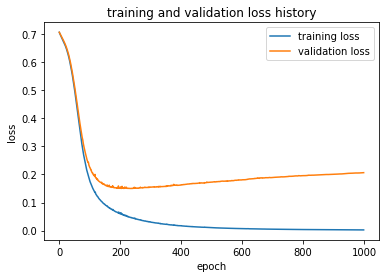

In [21]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('training and validation loss history')

Text(0.5,1,'training and validation accuracy history')

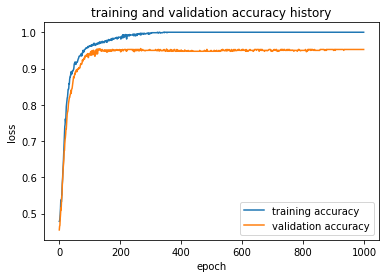

In [22]:
plt.plot(history.history['acc'], label = 'training accuracy')
plt.plot(history.history['val_acc'], label = 'validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('training and validation accuracy history')

You can tell the model is overfitting because after epoch ~300, the validation loss begins to slowly increase and the validation accuracy stays constant.

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

**Note: Due to computational constraints, I won't perform full cross validation to select regularization parameters and, instead, will simply hold out a validation set.**

### Baseline

In [23]:
baseline_loss = history.history['val_loss'][-1]
baseline_acc = history.history['val_acc'][-1]
print("the baseline loss is {} and the baseline accuracy is {}".format(baseline_loss, baseline_acc))

the baseline loss is 0.20637527942657471 and the baseline accuracy is 0.9525


In [24]:
model.evaluate(x_test_final, y_test_final)

800/800 [==============================] - 0s 26us/step


[0.15103098668623716, 0.95]

### L1 Regularization

In [25]:
def train_model_l1(r, x, y, epochs = 1000, batch_size = 128, input_dim = 28*28,  validation_split=.5):
    model = Sequential()
    model.add(Dense(units=100, activation='relu', input_dim=input_dim, kernel_regularizer = regularizers.l1(r)))
    model.add(Dense(units=100, activation='relu', kernel_regularizer = regularizers.l1(r)))
    model.add(Dense(units=100, activation='relu', kernel_regularizer = regularizers.l1(r)))
    model.add(Dense(units=2, activation='relu', kernel_regularizer = regularizers.l1(r)))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(x, y, epochs = epochs, batch_size=batch_size, validation_split = validation_split, verbose = 0)
    return history.history['val_loss'][-1], history.history['val_acc'][-1]

In [26]:
reg_param = [0.0001, 0.001, 0.01, 0.1]
loss_results_l1 = {}
acc_results_l1 = {}
for r in reg_param:
    print('regularization parameter:', r)
    loss, acc = train_model_l1(r, x_train_final, y_train_final, epochs = 2000)
    loss_results_l1[r] = loss 
    acc_results_l1[r] = acc

regularization parameter: 0.0001
regularization parameter: 0.001
regularization parameter: 0.01
regularization parameter: 0.1


### L2 Regularization

In [27]:
def train_model_l2(r, x, y, epochs = 1000, batch_size = 128, input_dim = 28*28,  validation_split=.5):
    model = Sequential()
    model.add(Dense(units=100, activation='relu', input_dim=input_dim, kernel_regularizer = regularizers.l2(r)))
    model.add(Dense(units=100, activation='relu', kernel_regularizer = regularizers.l2(r)))
    model.add(Dense(units=100, activation='relu', kernel_regularizer = regularizers.l2(r)))
    model.add(Dense(units=2, activation='relu', kernel_regularizer = regularizers.l2(r)))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(x, y, epochs = epochs, batch_size=batch_size, validation_split = validation_split, verbose = 0)
    return history.history['val_loss'][-1], history.history['val_acc'][-1]

In [28]:
reg_param = [0.0001, 0.001, 0.01, 0.1]
loss_results_l2 = {}
acc_results_l2 = {}
for r in reg_param:
    print('regularization parameter:', r)
    loss, acc = train_model_l1(r, x_train_final, y_train_final, epochs = 2000)
    loss_results_l2[r] = loss 
    acc_results_l2[r] = acc

regularization parameter: 0.0001
regularization parameter: 0.001
regularization parameter: 0.01
regularization parameter: 0.1


### Dropout

In [29]:
from keras.layers import Dropout

In [30]:
def train_model_dropout(r, x, y, epochs = 1000, batch_size = 128, input_dim = 28*28,  validation_split=.5):
    model = Sequential()
    model.add(Dense(units=100, activation='relu', input_dim=28*28))
    model.add(Dropout(r))
    model.add(Dense(units=100, activation='relu')) 
    model.add(Dropout(r))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(r))
    model.add(Dense(units=2, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(x, y, epochs = epochs, batch_size=batch_size, validation_split = validation_split, verbose = 0)
    return history.history['val_loss'][-1], history.history['val_acc'][-1]

In [31]:
reg_param = [0.1,0.2,0.3,0.4]
loss_results_dropout = {}
acc_results_dropout = {}
for r in reg_param:
    print('regularization parameter:', r)
    loss, acc = train_model_dropout(r, x_train_final, y_train_final, epochs = 2000)
    loss_results_dropout[r] = loss 
    acc_results_dropout[r] = acc

regularization parameter: 0.1
regularization parameter: 0.2
regularization parameter: 0.3
regularization parameter: 0.4


### Compare results

Text(0,0.5,'accuracy')

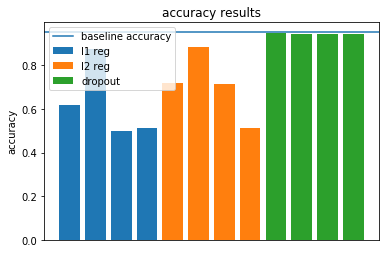

In [32]:
plt.bar(np.arange(0,4,1), acc_results_l1.values(), label = "l1 reg")
plt.bar(np.arange(4,8,1), acc_results_l2.values(), label = "l2 reg")
plt.bar(np.arange(8,12,1), acc_results_dropout.values(), label = 'dropout')
plt.axhline(baseline_acc, label = 'baseline accuracy')
plt.legend()
plt.title('accuracy results')
plt.xticks([])
plt.ylabel('accuracy')

Text(0,0.5,'binary cross-entropy')

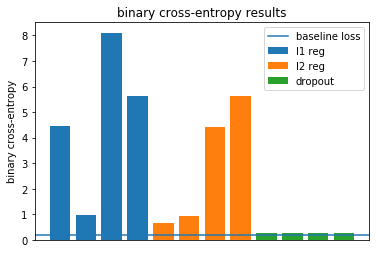

In [33]:
plt.bar(np.arange(0,4,1), loss_results_l1.values(), label = "l1 reg")
plt.bar(np.arange(4,8,1), loss_results_l2.values(), label = "l2 reg")
plt.bar(np.arange(8,12,1), loss_results_dropout.values(), label = 'dropout')
plt.axhline(baseline_loss, label = 'baseline loss')
plt.legend()
plt.title('binary cross-entropy results')
plt.xticks([])
plt.ylabel('binary cross-entropy')

The dropout model performs the best. Let's see which model performed the best.

In [34]:
best_dropout_param = list(acc_results_dropout.keys())[np.argmax(list(acc_results_dropout.values()))]
print("The best dropout parameter is", best_dropout_param)

The best dropout parameter is 0.1


In [35]:
best_dropout_param

0.1

### Data augmentation

Let's see if we can improve performance by augmenting our data with transformed images

In [43]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Input
from keras.models import Model


In [44]:
inp = Input(shape= (28, 28, 1))
x = Flatten()(inp)
x = Dense(100, activation='relu')(x)
x = Dropout(best_dropout_param)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(best_dropout_param)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(best_dropout_param)(x)
out = Dense(units=2, activation='sigmoid')(x)

model_dropout = Model(inputs=inp, outputs=out)

In [45]:
def preprocess(x, y):    
    select = np.logical_or(y == 4, y == 9)
    x_subset = x[select]
    y_subset = y[select]

    idx = np.random.randint(len(y_subset), size=800)
    x_800 = x_subset[idx]
    y_800 = y_subset[idx]

    y_binary = np.array([0 if y == 4 else 1 for y in y_800])

    # Preprocess data using keras.utils.to_categorical
    # your code here 
    y_final = keras.utils.to_categorical(y_binary)

    # scale the data otherwise reLU can become unstable 
    # your code here 
    x_reshape = x_800.reshape(x_800.shape[0], 28, 28, 1)
    x_final = x_reshape.astype('float32')
    
    return x_final, y_final

x_train_final, y_train_final = preprocess(x_train, y_train)

x_test_final, y_test_final = preprocess(x_test, y_test)

In [46]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2, 
    zoom_range=0.2,
    rotation_range = 0.2,
)
# fit parameters from data
datagen.fit(x_train_final)

In [47]:
train_generator = datagen.flow(x_train_final, y_train_final, batch_size=128)
model_dropout.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
history = model_dropout.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) / 128, 
    epochs=50 # need to drop down epochs due to using generator
)

Epoch 1/50
469/468 [==============================] - 9s 20ms/step - loss: 0.5837 - acc: 0.7221
Epoch 2/50
469/468 [==============================] - 9s 19ms/step - loss: 0.2328 - acc: 0.9224
Epoch 3/50
469/468 [==============================] - 10s 21ms/step - loss: 0.1417 - acc: 0.9513
Epoch 4/50
469/468 [==============================] - 10s 21ms/step - loss: 0.1116 - acc: 0.9616
Epoch 5/50
469/468 [==============================] - 11s 24ms/step - loss: 0.0879 - acc: 0.9711
Epoch 6/50
469/468 [==============================] - 13s 28ms/step - loss: 0.0694 - acc: 0.9786
Epoch 7/50
469/468 [==============================] - 12s 25ms/step - loss: 0.0542 - acc: 0.9838
Epoch 8/50
469/468 [==============================] - 9s 20ms/step - loss: 0.0427 - acc: 0.9875
Epoch 9/50
469/468 [==============================] - 10s 22ms/step - loss: 0.0344 - acc: 0.9909
Epoch 10/50
469/468 [==============================] - 9s 19ms/step - loss: 0.0270 - acc: 0.9929
Epoch 11/50
469/468 [============

### Assess performance on test set

In [49]:
model_dropout.evaluate(x_test_final, y_test_final)

800/800 [==============================] - 0s 615us/step


[0.5778060766983714, 0.96375]

In [50]:
def preprocess(x, y):    
    select = np.logical_or(y == 4, y == 9)
    x_subset = x[select]
    y_subset = y[select]

    idx = np.random.randint(len(y_subset), size=800)
    x_800 = x_subset[idx]
    y_800 = y_subset[idx]

    y_binary = np.array([0 if y == 4 else 1 for y in y_800])

    # Preprocess data using keras.utils.to_categorical
    # your code here 
    y_final = keras.utils.to_categorical(y_binary)

    # scale the data otherwise reLU can become unstable 
    # your code here 
    x_scaled = x_800/255
    x_final = x_scaled.reshape(-1,28*28)
    
    return x_final, y_final

x_train_final, y_train_final = preprocess(x_train, y_train)

x_test_final, y_test_final = preprocess(x_test, y_test)

In [51]:
model.evaluate(x_test_final, y_test_final)

800/800 [==============================] - 0s 45us/step


[0.2820719419885427, 0.92875]

We got a ~4% increase in test set accuracy.

### Save model

In [52]:
model_dropout.save("regularized_model")

In [54]:
test_model = keras.models.load_model('./regularized_model')

In [55]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
__________